# 目的
- エンゼルの出現確率を購入者毎に予測する
- 独立に予測するのと、階層モデルで予測するのを試す

In [1]:
import os, sys
import numpy as np
import pandas as pd
import scipy.stats as stats

import itertools
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

import ChocoUtils as cu

In [2]:
sns.set()

# データの取得

In [3]:
data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="campaign is not 1 and taste is not 10")
data = data.drop(columns=['shop', 'factory'])

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE campaign is not 1 and taste is not 10;
Shape of MeasurementData(record_num, n_columns) : (290, 14)


In [4]:
# 銀のエンゼルのフラグデータ
data['silver'] = [1 if a == 1 else 0 for a in data['angel'].values]
# 金のエンゼル
data['gold'] = [1 if a == 2 else 0 for a in data['angel'].values]

# 購入者の調整
data['buyer'] = ['ピシャイ' if a in 'ピシャイ/佐藤' else a for a in data['buyer'].values]


In [5]:
data.head()

,measure_date,best_before,prd_number,weight,box_weight,ball_number,angel,campaign,taste,buyer,net_weight,mean_weight,silver,gold
0,2017-12-04,2018-02-01,BA6,34.513,4.710,16,0,2,0,根本,29.803,1.862688,0,0
1,2017-12-04,2018-02-01,AA6,33.644,4.731,16,0,2,0,根本,28.913,1.807062,0,0
2,2017-12-10,2018-09-01,CA9,31.103,4.776,15,0,2,1,時田,26.327,1.755133,0,0
3,2017-12-10,2018-09-01,CA9,31.477,4.767,15,0,2,1,時田,26.710,1.780667,0,0
4,2017-12-10,2018-09-01,CA9,31.615,4.777,15,0,2,1,時田,26.838,1.789200,0,0


In [6]:
# 購入者を限定する
data = data.query('buyer in ["ピシャイ", "西田", "時田"]')

grp = data.groupby(['buyer'])
print(grp.count()[['net_weight']])

       net_weight
buyer            
ピシャイ           80
時田            142
西田             59


# エンゼル出現確率の推定

## 購入者ごとに独立に推定

In [7]:
name_dict = {'ピシャイ':'pichai', '時田':'tokita', '西田':'nishida'}

In [8]:
buyer = data['buyer'].values
buyer_idx = pd.Categorical(data['buyer']).codes
buyer_cat = pd.Categorical(data['buyer']).categories
data['buyer_idx'] = buyer_idx
lst_buyer = list(set(buyer_idx))
print(buyer_cat)
print(set(buyer_idx))

Index(['ピシャイ', '時田', '西田'], dtype='object')
{0, 1, 2}


In [9]:
total_counts = data.groupby(['buyer_idx']).count()['silver'].values
angel_counts = data.query('silver > 0').groupby(['buyer_idx']).count()['silver'].values

print('total_count : {}'.format(total_counts))
print('angel_count : {}'.format(angel_counts))


total_count : [ 80 142  59]
angel_count : [5 6 2]


max_theta : 0.05050505050505051


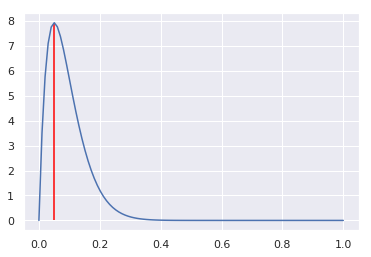

In [10]:
# 事前分布の形確認
(a, b) = (2.0, 20.0)

x = np.linspace(0, 1, 100)
y = stats.beta(a, b).pdf(x)
plt.plot(x, y)
plt.vlines(x=x[y.argmax()], ymin=0, ymax=max(y), colors='red')
print('max_theta : {}'.format(x[y.argmax()]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 5500/5500 [00:05<00:00, 996.87it/s] 
The acceptance probability does not match the target. It is 0.8801963907382168, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f666e48>,
      dtype=object)

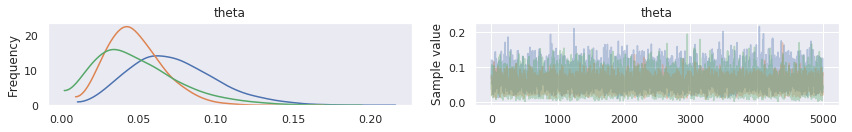

In [11]:
with pm.Model() as comparing_buyer_i:
    theta = pm.Beta('theta', alpha=1, beta=1, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', n=total_counts[lst_buyer], p=theta[lst_buyer], observed=angel_counts[lst_buyer])
    
    trace_iso = pm.sample(5000, chains=1)
pm.traceplot(trace_iso)

In [12]:
pm.summary(trace_iso)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
theta__0,0.072902,0.028149,0.000305,0.021305,0.127312
theta__1,0.048291,0.018133,0.000244,0.016304,0.083870
theta__2,0.049610,0.027466,0.000388,0.004440,0.103215


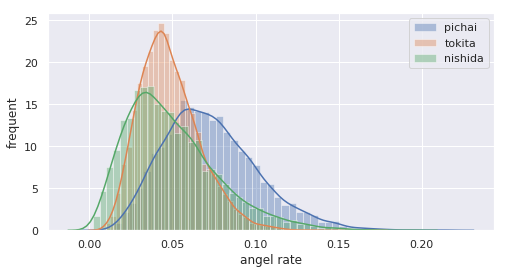

In [13]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

for i in np.arange(len(buyer_cat)):
    sns.distplot(trace_iso['theta'][:,i], label=name_dict[buyer_cat[i]], ax=ax)
ax.legend()
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')
plt.savefig('buyer_effect_iso.png')

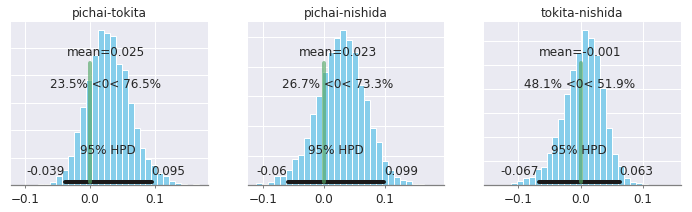

In [14]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, len(lst_buyer)), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, len(lst_buyer)), 2):
    theta_diff = trace_iso['theta'][:, i] - trace_iso['theta'][:, j]
    pm.plot_posterior(theta_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(name_dict[buyer_cat[i]], name_dict[buyer_cat[j]]))
    cnt+=1
plt.savefig('buyer_effect_diff_isomodel.png')

## 購入者の性質を加える
- 真の出現率は決まっているはず(真の確率を$p$とする)
- 購入者毎の運の要素が入ってくる（不正行為かも、独自の購入戦略があるのかも）可能性がある
  - 購入者毎の特性を個人差$u_i$とする
- エンゼルの出現は確率$\theta_i$の二項分布
- 確率$\theta_i$は以下のロジットリンク関数で線形モデルを仮定
$$
logit(\theta_i) = p + u_i
$$

- $p$、$u_i$は正規分布を事前分布とする
  - 要検討

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [u, p, su]
Sampling 3 chains: 100%|██████████| 10500/10500 [00:07<00:00, 1480.96draws/s]
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6963398905192857, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13016c940>,
      dtype=object)

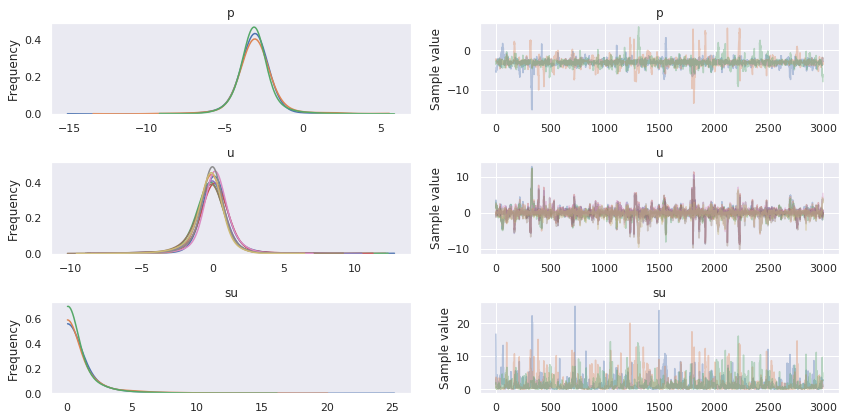

In [15]:
with pm.Model() as comparing_buyer_m1:
    su = pm.HalfNormal('su', sd=10)
    p = pm.Normal('p', mu=0, sd=10)
    u = pm.Normal('u', mu=0, sd=su, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', 
                        n=total_counts[lst_buyer], 
                        p=pm.math.sigmoid(p+u[lst_buyer]), observed=angel_counts[lst_buyer])
    
    trace_h1 = pm.sample(3000, chains=3)
pm.traceplot(trace_h1)

In [16]:
pm.summary(trace_h1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,-3.078691,1.172001,0.038205,-5.369216,-0.925158,866.946608,1.001140
u__0,0.176448,1.187071,0.038914,-1.989398,2.537341,880.152097,1.000895
u__1,-0.077234,1.173299,0.037774,-2.236193,2.189250,885.606305,1.000807
u__2,-0.237226,1.218467,0.038943,-2.518080,2.128743,902.245995,1.001193
su,1.302939,1.802917,0.056739,0.082287,4.717464,942.263807,1.001703


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12f6f79b0>,
      dtype=object)

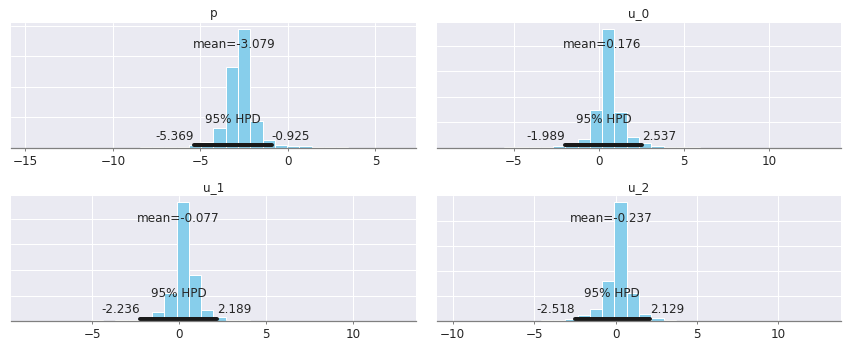

In [17]:
pm.plot_posterior(trace_h1, varnames=['p', 'u'])

Text(0, 0.5, 'frequent')

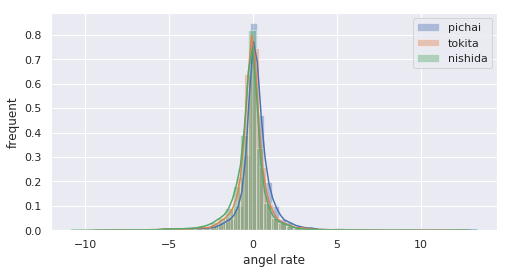

In [18]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

for i in np.arange(len(buyer_cat)):
    sns.distplot(trace_h1['u'][:,i], label=name_dict[buyer_cat[i]], ax=ax)
ax.legend()
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')

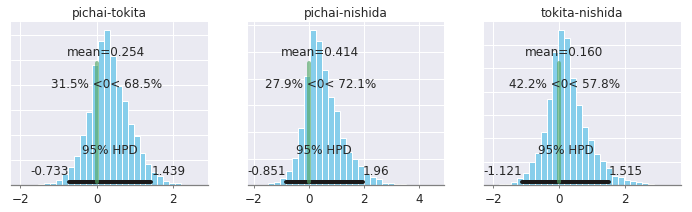

In [19]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, 3), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, 3), 2):
    u_diff = trace_h1['u'][:, i] - trace_h1['u'][:, j]
    pm.plot_posterior(u_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(name_dict[buyer_cat[i]], name_dict[buyer_cat[j]]))
    cnt+=1
plt.savefig('buyer_effect_diff_h1model.png')

In [20]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [21]:
post_min = pm.summary(trace_h1).loc['p', 'hpd_2.5']
post_mean = pm.summary(trace_h1).loc['p', 'mean']
post_max = pm.summary(trace_h1).loc['p', 'hpd_97.5']
print('{} < {} < {}'.format(sigmoid(post_min), sigmoid(post_mean), sigmoid(post_max)))

0.004636188655943219 < 0.043994837844675574 < 0.2839081616935929


## 階層モデルとして、全体を統括するパラメータがあると仮定
- 真の出現率を決めるパラメータがあるはず
- 購入者毎の運によって↑のパラメータに基づいたパラメータがサンプルされる
- エンゼルの出現は確率$\theta_i$の二項分布
- $\theta$の事前分布はベータ分布
- ベータ分布のパラメータに事前分布を設定

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [theta, beta, alpha]
Sampling 3 chains: 100%|██████████| 7500/7500 [00:07<00:00, 970.23draws/s]
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6671738537017018, but should be close to 0.8. Try to increase the number of tuning steps.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7115286934956989, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1314b3208>,
      dtype=object)

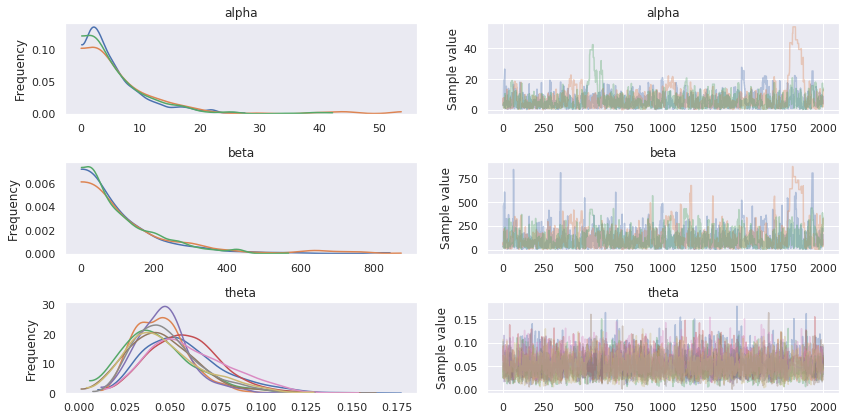

In [22]:
with pm.Model() as comparing_buyer_m2:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', n=total_counts[lst_buyer], p=theta[lst_buyer], observed=angel_counts[lst_buyer])
    
    trace_h2 = pm.sample(2000, chains=3)
pm.traceplot(trace_h2)

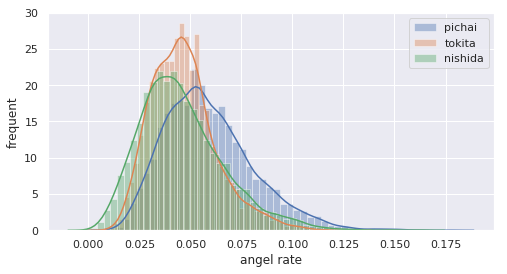

In [23]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

for i in np.arange(len(buyer_cat)):
    sns.distplot(trace_h2['theta'][:,i], label=name_dict[buyer_cat[i]], ax=ax)
ax.legend()
ax.set_xlabel('angel rate')
ax.set_ylabel('frequent')
plt.savefig('buyer_effect_h2model.png')

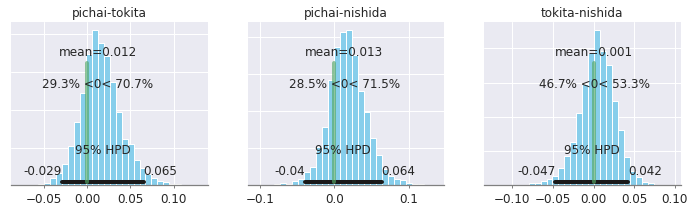

In [24]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, len(lst_buyer)), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, len(lst_buyer)), 2):
    theta_diff = trace_h2['theta'][:, i] - trace_h2['theta'][:, j]
    pm.plot_posterior(theta_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(name_dict[buyer_cat[i]], name_dict[buyer_cat[j]]))
    cnt+=1
plt.savefig('buyer_effect_diff_h2model.png')

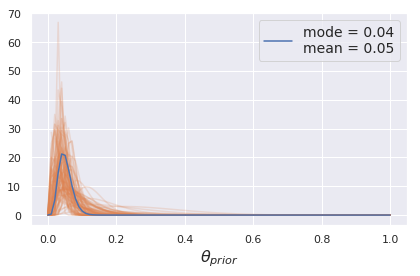

In [25]:
# thetaの事前分布
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h2), size=100):
    pdf = stats.beta(trace_h2['alpha'][i], trace_h2['beta'][i]).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

dist = stats.beta(trace_h2['alpha'].mean(), trace_h2['beta'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel('$\\theta_{prior}$', fontsize=16)
plt.tight_layout()
plt.savefig('buyer_effect_prior_h2model.png', dpi=300, figsize=(5.5, 5.5))

## ベルヌーイ分布を使って書き直す

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 5500/5500 [00:03<00:00, 1725.19it/s]
The acceptance probability does not match the target. It is 0.8822385135478129, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132961240>,
      dtype=object)

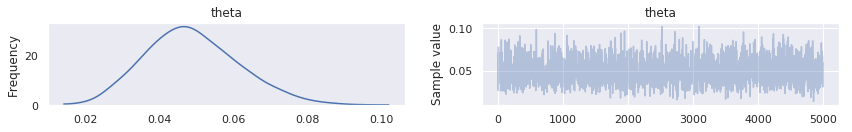

In [29]:
y_angel = data['silver'].values
with pm.Model() as choco:
    theta = pm.Beta('theta', alpha=1, beta=1)
    
    angel = pm.Bernoulli('angel', p=theta, observed=y_angel)
    
    trace = pm.sample(5000, chains=1)
pm.traceplot(trace)

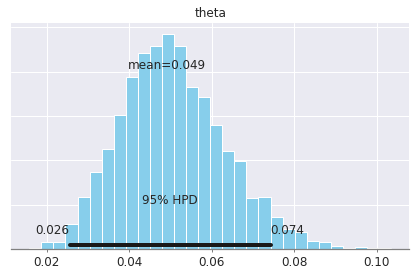

In [31]:
pm.plot_posterior(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 5500/5500 [00:04<00:00, 1266.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1333545f8>,
      dtype=object)

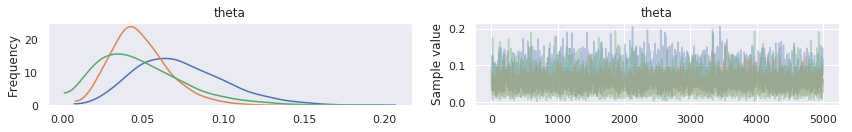

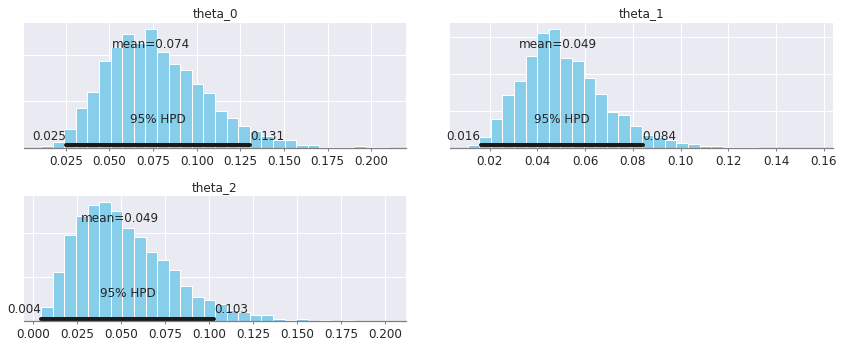

In [33]:
with pm.Model() as choco:
    theta = pm.Beta('theta', alpha=1, beta=1, shape=len(lst_buyer))
    
    angel = pm.Bernoulli('angel', p=theta[buyer_idx], observed=y_angel)
    
    trace = pm.sample(5000, chains=1)
pm.traceplot(trace)
pm.plot_posterior(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta, beta, alpha]
100%|██████████| 5500/5500 [00:13<00:00, 393.86it/s]
There were 303 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<matplotlib.axes._subplots.AxesSubplot object at 0x13322bf28>,
      dtype=object)

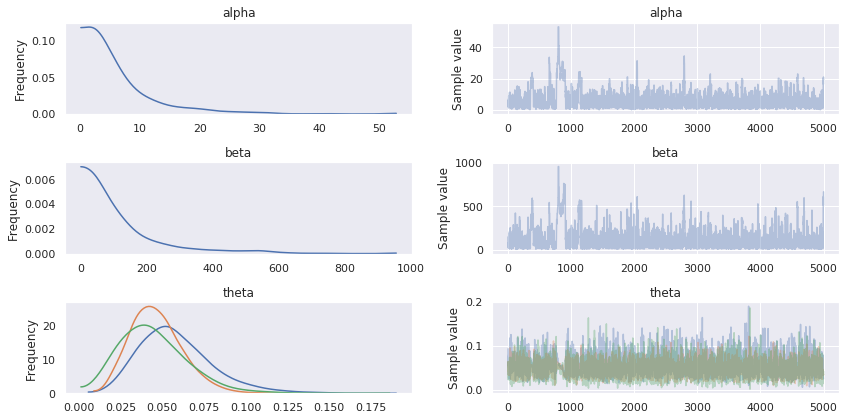

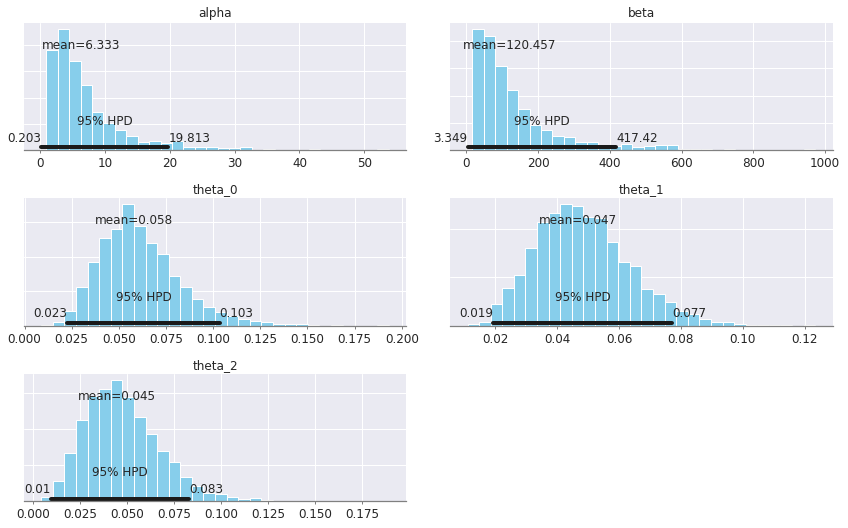

In [34]:
with pm.Model() as choco:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(lst_buyer))
    
    angel = pm.Bernoulli('angel', p=theta[buyer_idx], observed=y_angel)
    
    trace = pm.sample(5000, chains=1)
pm.traceplot(trace)
pm.plot_posterior(trace)